<a href="https://colab.research.google.com/github/ritusinha128/health-informatics-project/blob/main/chest_cancer/Chest_Cancer_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
files.upload()

Saving Kaggle.json to Kaggle.json


{'Kaggle.json': b'{"username":"harshithasanjeev","key":"75dae23f53cb9eb626e75bc420c8f7e9"}'}

In [1]:
from google.colab import files
files.upload()

Saving Kaggle.json to Kaggle.json


{'Kaggle.json': b'{"username":"harshithasanjeev","key":"75dae23f53cb9eb626e75bc420c8f7e9"}'}

In [4]:
!mkdir ~/.kaggle_files

In [6]:
!cp Kaggle.json ~/.kaggle/kaggle.json

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d unaissait/curated-chest-xray-image-dataset-for-covid19

100% 3.49G/3.49G [00:46<00:00, 66.1MB/s]
100% 3.49G/3.49G [00:46<00:00, 81.4MB/s]


In [9]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/curated-chest-xray-image-dataset-for-covid19.zip'
extraction_directory = '/content'

# Check if the extraction directory exists, create if it does not
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print(f'Files extracted to {extraction_directory}')

Files extracted to /content


In [10]:
import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt


from torch import nn
from typing import Any
from torch.backends import mps
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter


bar = "="
version = torch.__version__
writer = SummaryWriter('./logs')

if mps.is_available() :
    device = torch.device('mps')
elif torch.cuda.is_available() :
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

print(f'{bar*10}Device INFO{bar*10}')
print(f'PyTorch Version :{version}')
print(f'Device :{device}')
print(bar*31)

==========Device INFO==========
PyTorch Version :2.2.1+cu121
Device :cpu


In [11]:
transformer = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.ColorJitter(saturation=0.5),
    transforms.ToTensor()
])

In [12]:
lable_name = ['Covid', 'Normal',  'Pneumonia Bacterial', 'Viral Pneumonia']
dataset = ImageFolder('../content/Curated X-Ray Dataset/', transform=transformer)
dataset.classes

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

In [13]:
COV_DIR = "/content/Curated X-Ray Dataset/COVID-19"
NORM_DIR = "/content/Curated X-Ray Dataset/Normal"
BAC_DIR = "/content/Curated X-Ray Dataset/Pneumonia-Bacterial"
VIR_DIR = "/content/Curated X-Ray Dataset/Pneumonia-Viral"

In [14]:
folder = os.makedirs ('/kaggle/working/dataset')

In [15]:
directories = {
    'covid-19': "/content/Curated X-Ray Dataset/COVID-19",
    'Normal': "/content/Curated X-Ray Dataset/Normal",
    'bacterial': "/content/Curated X-Ray Dataset/Pneumonia-Bacterial",
    'viral': "/content/Curated X-Ray Dataset/Pneumonia-Viral"
}


# Count the number of images in each directory
for class_name, directory in directories.items():
    num_images = len(os.listdir(directory))
    print(f"Number of images in {class_name} directory: {num_images}")

Number of images in covid-19 directory: 1281
Number of images in Normal directory: 3270
Number of images in bacterial directory: 3001
Number of images in viral directory: 1656


In [27]:
from sklearn.model_selection import train_test_split

data_train=[]
labels_train=[]
data_test=[]
labels_test=[]
data_val=[]
labels_val=[]

COVID_files = os.listdir(COV_DIR)
Normal_files = os.listdir(NORM_DIR)
Bacterial_files = os.listdir(BAC_DIR)
Viral_files = os.listdir(VIR_DIR)

In [28]:
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

In [29]:
COVID_train_files, COVID_test_files = train_test_split(COVID_files, test_size=0.20, random_state=42)
COVID_train_files, COVID_val_files = train_test_split(COVID_train_files, test_size=0.20, random_state=42)

Normal_train_files, Normal_test_files = train_test_split(Normal_files, test_size=0.20, random_state=42)
Normal_train_files, Normal_val_files = train_test_split(Normal_train_files, test_size=0.20, random_state=42)

Bacterial_train_files, Bacterial_test_files = train_test_split(Bacterial_files, test_size=0.20, random_state=42)
Bacterial_train_files, Bacterial_val_files = train_test_split(Bacterial_train_files, test_size=0.20, random_state=42)

Viral_train_files, Viral_test_files = train_test_split(Viral_files, test_size=0.20, random_state=42)
Viral_train_files, Viral_val_files = train_test_split(Viral_train_files, test_size=0.20, random_state=42)

In [30]:
for a in COVID_train_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(0)

for a in COVID_test_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(0)

for a in COVID_val_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(0)

In [31]:
for b in Normal_train_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(1)

for b in Normal_test_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(1)

for b in Normal_val_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(1)

In [32]:
for c in Bacterial_train_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(2)

for c in Bacterial_test_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(2)

for c in Bacterial_val_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(2)

In [33]:
for c in Viral_train_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(3)

for c in Viral_test_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(3)

for c in Viral_val_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(3)

In [34]:
print("Number of images in train lists :")
print("COVID-19:", labels_train.count(0))
print("Normal:", labels_train.count(1))
print("Pneumonia-Bacterial:", labels_train.count(2))
print("Pneumonia-Viral:", labels_train.count(3))

print("\n Number of images in test lists :")
print("COVID-19:", labels_test.count(0))
print("Normal:", labels_test.count(1))
print("Pneumonia-Bacterial:", labels_test.count(2))
print("Pneumonia-Viral:", labels_test.count(3))

print("\n Number of images in validation lists :")
print("COVID-19:", labels_val.count(0))
print("Normal:", labels_val.count(1))
print("Pneumonia-Bacterial:", labels_val.count(2))
print("Pneumonia-Viral:", labels_val.count(3))

Number of images in train lists :
COVID-19: 819
Normal: 2092
Pneumonia-Bacterial: 1920
Pneumonia-Viral: 1059

 Number of images in test lists :
COVID-19: 257
Normal: 654
Pneumonia-Bacterial: 601
Pneumonia-Viral: 332

 Number of images in validation lists :
COVID-19: 205
Normal: 524
Pneumonia-Bacterial: 480
Pneumonia-Viral: 265


In [35]:
x_train = np.array (data_train)
y_train = np.array (labels_train)

x_test = np.array (data_test)
y_test = np.array (labels_test)

x_val = np.array (data_val)
y_val = np.array (labels_val)

In [37]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Check the shapes of the resulting sets
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_val shape:", x_val.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

x_train shape: (5890, 224, 224, 3)
x_test shape: (1844, 224, 224, 3)
x_val shape: (1474, 224, 224, 3)
y_train shape: (5890, 4)
y_test shape: (1844, 4)
y_val shape: (1474, 4)


In [38]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    horizontal_flip=True,
    fill_mode="nearest")

batch_size = 32
image_size = (224, 224)

train_dataset = datagen.flow(x_train,
                            y_train,
                             batch_size=batch_size,
                             shuffle=True)

test_dataset = datagen.flow(x_test,
                            y_test,
                            batch_size=batch_size,
                            shuffle=True)

validation_dataset = datagen.flow(x_val,
                                  y_val,
                                  batch_size=batch_size,
                                  shuffle=False)

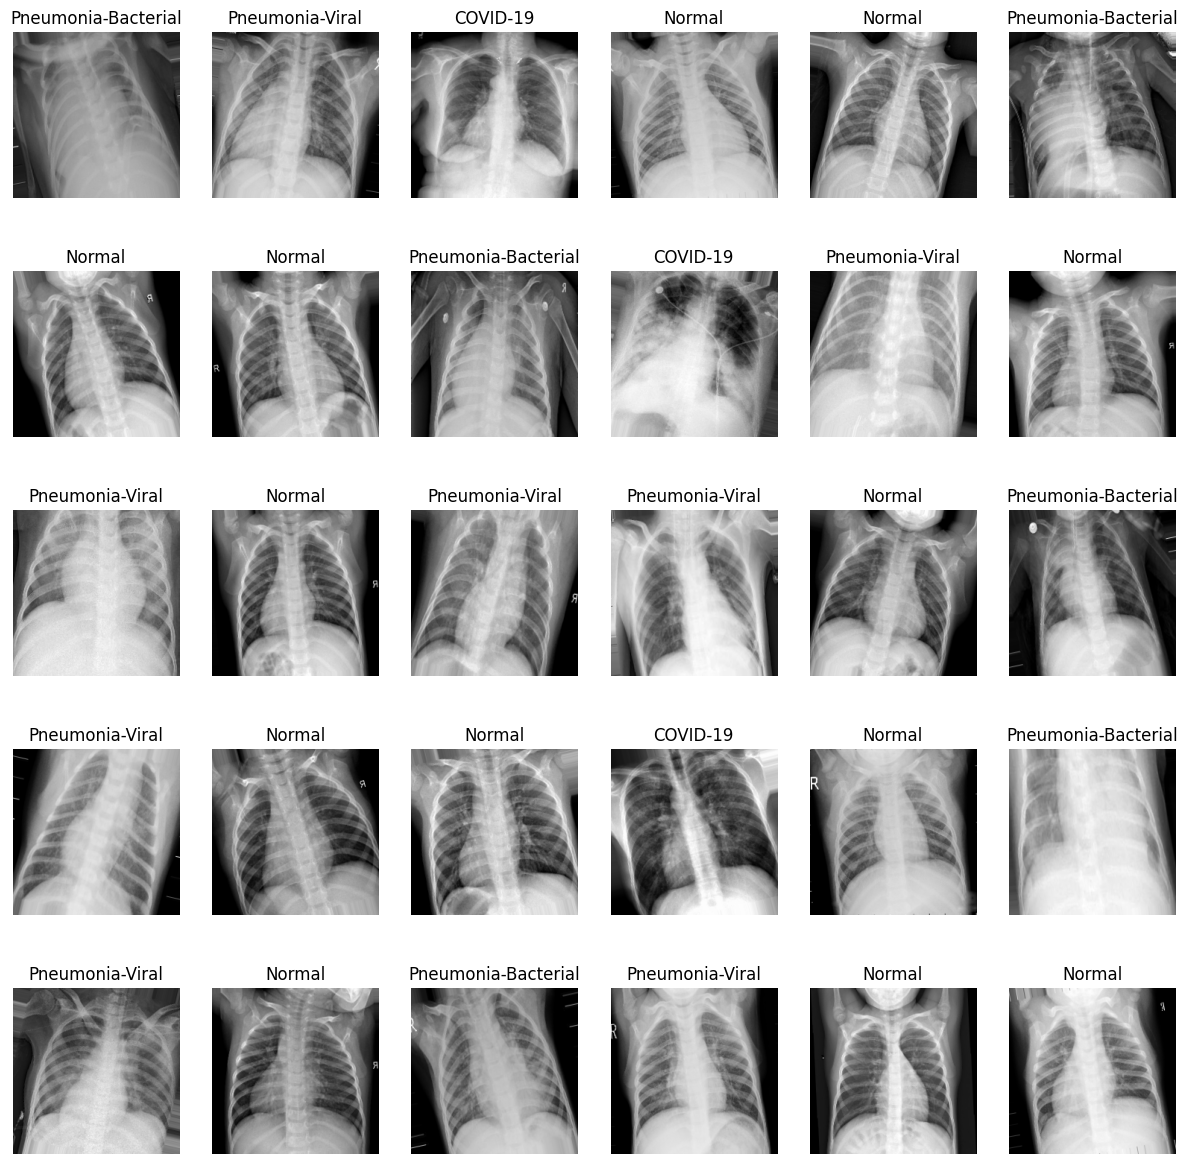

In [39]:
import matplotlib.pyplot as plt

# Get the first batch from the train dataset
batch_images, batch_labels = train_dataset.next()

# Define class names
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

# Plot the first 30 images
plt.figure(figsize=(15, 15))
for i in range(30):
    plt.subplot(5, 6, i + 1)
    plt.imshow(batch_images[i])
    plt.title(class_names[np.argmax(batch_labels[i])])
    plt.axis("off")

plt.show()